## Step 1 Installing Modules
We will now download and install the EEG-GAN package


In [3]:
!pip install eeggan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.5/39.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 0.2. Loading Modules

In [1]:
#Load other modules specific to this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
from scipy import signal
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import eeggan

#Create a print formatting class
class printFormat:
    bold = '\033[1m'
    italic = '\033[3m'
    end = '\033[0m'

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

In [32]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Step 2. AE-GAN

EEGGAN Functions


In [ ]:
!eeggan gan_training help
!eeggan autoencoder_training help
!eeggan visualize help
!eeggan generate_samples help

## Step 2.2.A. Training the AE-GAN

The GAN within `eeggan` has two different structures dependent on whether we are training it on time-series EEG data or encoded EEG data. The former would take each of your samples as is and learn to generate them directly. The latter instead transforms each of your samples using an autoencoder and then learns to generate the encoded space. We highly suggest using the autoencoder GAN (AE-GAN) as it speeds up training and results in better generated data, but we will here show how to use both structures, starting with the AE-GAN.

Although more efficient, the drawback of using the AE-GAN is that you first need to train an autoencoder (however, training is very fast) and then you train the GAN with the `autoencoder` parameter.

We will first train our autoencoder with the following parameters:
- <b>data</b>: Determines the training dataset.
- <b>save_name</b>: Determines the autoencoder filename. This will automatically be placed within the `trained_ae` directory.
- <b>kw_channel</b>: This is used to inform the autoencoder of different electrodes.
- <b>target</b>: This informs the autoencoder which dimension should be reduced. Here we will use `time` to reduce our samples but we could also reduce our channel dimension using `channel` or both time and channel dimensions using `full`.
- <b>time_out</b>: This is the size of the reduced time dimension. For example, if your samples are 100 datapoints and this parameter is 50 datapoints, the data will be reduced to half of its size.<br>
&emsp;&emsp;-*If you are reducing the channel dimension with `target=channel` then instead use the parameter `channels_out`.*<br>
&emsp;&emsp;-*If you are reducing both dimensions with `target=full`, use both `time_out` and `channels_out`.*<br>
- <b>n_epochs</b>: Determines number of epochs to train the autoencoder.<br>
&emsp;&emsp;-*Here we only use 10 epochs to demonstrate the process but this will result in a very under-trained autoencoder. <br>
&emsp;&emsp;In Williams, Weinhardt et al., (in prep, 2024) using the AE-GAN we trained the autoencoder for 2000 epochs.*
- <b>seed</b>: Sets seed for reproducability.<br>


In [ ]:
from os import rename
data = '/content/drive/MyDrive/brainhack/combined_raw_rest.csv'
data2 = '/content/drive/MyDrive/brainhack/combined_raw_face.csv'

df = pd.read_csv(data)
df.drop(columns='index', inplace=True)
df.drop(columns='unixTimestamp', inplace=True)

columns = df.columns
df.columns = [None] * df.shape[1]
original_length = len(df)
target_length = 10000
window_size = original_length // target_length  # Calculate the window size
df = df.groupby(df.index // window_size).mean()
df.reset_index(drop=True, inplace=True)

df1 = df.T
df1.columns = [f'Time{i}' for i in range(df1.shape[1])]
df1.reset_index(drop=True, inplace=True)
df1['channels'] = columns
df1['channels'] = pd.factorize(df1['channels'])[0].astype(float) + 1
df1['Target'] = np.zeros(len(df1))
df = pd.read_csv(data2)
df.drop(columns='index', inplace=True)
df.drop(columns='unixTimestamp', inplace=True)
columns = df.columns
df.columns = [None] * df.shape[1]
df = df.groupby(df.index // window_size).mean()
df.reset_index(drop=True, inplace=True)
df = df.astype(float)
df2 = df.T
df2.columns = [f'Time{i}' for i in range(df2.shape[1])]
df2.reset_index(drop=True, inplace=True)
df2['channels'] = columns
df2['channels'] = pd.factorize(df2['channels'])[0].astype(float) + 1
df2['Target'] = np.ones(len(df2))

df = pd.concat([df1, df2])
df.dropna(axis=1).to_csv('/content/drive/MyDrive/brainhack/combined.csv', index=False)
empiricalHeaders = np.genfromtxt('/content/drive/MyDrive/brainhack/combined.csv', delimiter=',', names=True).dtype.names
empiricalEEG = np.genfromtxt('/content/drive/MyDrive/brainhack/combined.csv', delimiter=',', skip_header=1)

print(df)


        Time0        Time1        Time2        Time3        Time4  \
0   16.330295   736.653646   951.551649   673.394097  -121.256510   
1 -481.879340 -1000.000000 -1000.000000 -1000.000000 -1000.000000   
2  -60.546875    86.425781   299.533420   382.432726   349.229601   
3   -9.548611   -43.131510  -120.605469  -210.123698  -270.345052   
0 -126.627604  -257.975260  -209.201389  -150.010851  -117.078993   
1 -479.166667  -996.636285  -822.102865  -890.516493  -807.400174   
2  -66.080729  -128.580729  -126.410590  -142.415365  -136.555990   
3  -86.751302  -138.943142  -101.399740   -70.421007   -53.493924   

         Time5        Time6        Time7        Time8        Time9  ...  \
0  -968.478733  -999.891493  -661.295573   -15.190972  -261.067708  ...   
1 -1000.000000 -1000.000000 -1000.000000 -1000.000000 -1000.000000  ...   
2   265.516493   149.197049   194.769965   200.792101    81.271701  ...   
3  -272.189670  -241.156684  -186.143663  -131.022135  -109.700521  ...   
0  

In [31]:
# Train Autoencoder Parameters
data = '/content/drive/MyDrive/brainhack/combined.csv'
save_name = '/content/drive/MyDrive/brainhack/my_autoencoder.pt'
kw_channel = 'channels'
target = 'Time'
time_out = 100
n_epochs = 10
seed = 42

# Train the Autoencoder
!eeggan autoencoder_training data={data} learning_rate=0.00001 save_name={save_name} kw_channel={kw_channel} time_out={time_out} n_epochs={n_epochs} seed={seed}
#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

# Alternatively, you could have written all parameters in place:
# !eeggan autoencoder_training data='data/eeggan_training_example.csv' save_name='test_ae.pt' kw_channel='Electrode' target='time' time_out=50 n_epochs=10 seed=42

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: /content/drive/MyDrive/brainhack/combined.csv
Learning rate: 1e-05
Model save name: /content/drive/MyDrive/brainhack/my_autoencoder.pt
Channel label: channels
Encoded time series size: 100
Number of epochs: 10
Manual seed: True
-----------------------------------------

Training the first level of the autoencoder...
100% 10/10 [00:00<00:00, 15.73it/s, TRAIN LOSS: 0.499515, TEST LOSS: 0.484558]
Managing checkpoints...
Training the second level of the autoencoder...
100% 10/10 [00:11<00:00,  1.15s/it, TRAIN LOSS: 0.339739, TEST LOSS: 

Next, we will train the AE-GAN using the following parameters:
- <b>data</b>: Determines the training dataset
- <b>save_name</b>: Determines the GAN filename. This will automatically be placed within the `trained_models` directory.
- <b>autoencoder</b>: This points the GAN to the autoencoder that was previously trained. Including this parameter uses the AE-GAN structure, but if this parameter is not used the function will use a normal GAN structure. Again, we suggest using the AE-GAN whenever possible.
- <b>kw_condition</b>: This is used to inform the GAN of different conditions.
- <b>kw_channel</b>: This is used to inform the GAN of different electrodes.
- <b>patch_size</b>: This is the length of each token within the transformer. In other words, the time dimension will be cut into segments of this length. The `patch_size` must be a multiple of the time dimension length.<br>
&emsp;&emsp;-*The time dimension length for the AE-GAN is the embedded time length (50 in the autoencoder we trained above).*<br>
&emsp;&emsp;-*The time dimension length for the GAN is the sample length (100 in our current dataset).*<br>
&emsp;&emsp;-*So, a patch size of 10 would create 5 tokens of length 10 for the AE-GAN or 10 tokens of length 10 for the GAN.*<br>
- <b>n_epochs</b> : Determines number of epochs to train the GAN.<br>
&emsp;&emsp;-*Here we only use 10 epochs to demonstrate the process but this will result in a very under-trained GAN. <br>
&emsp;&emsp;In Williams, Weinhardt et al., (in prep, 2024) using the AE-GAN we trained the GAN for 2000 epochs.*
- <b>seed</b>: Sets seed for reproducability.<br>


*Note: If the **ddp** argument is provided, GANs will be trained using GPUs rather than CPUs*

<b>*Note: We are not here using the `my_autoencoder.pt` file that we trained, but instead are using a pretrained autoencoder `pretrained_autoencoder.pt`*</b>


In [33]:
#Train AE-GAN Parameters
data = '/content/drive/MyDrive/brainhack/combined.csv'
save_name = '/content/drive/MyDrive/brainhack/my_aegan.pt'
autoencoder = '/content/drive/MyDrive/brainhack/my_autoencoder.pt' #Uses the pretrained autoencoder
kw_conditions = 'Target'
# kw_channel = 'Aggregate_Delta','Aggregate_Theta', 'Aggregate_Alpha', 'Aggregate_Beta', 'Normalized_Aggregate'
kw_channel = 'channels'
patch_size = 50
n_epochs = 10
seed = 42

# Train the AE-GAN on CPUs
!eeggan gan_training data={data} autoencoder={autoencoder} save_name={save_name} discriminator_lr=0.00001 generator_lr=0.00001 kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}

# Train the AE-GAN on GPUs
# !eeggan gan_training ddp data={data} autoencoder={autoencoder} save_name={save_name} kw_conditions={kw_conditions} kw_channel={kw_channel} patch_size={patch_size} n_epochs={n_epochs} seed={seed}
# Note, on Google Colab you can start a GPU runtime by going to Runtime > Change runtime type > Hardware accelerator > GPU

#---------------------------------------------------------------------#
#---------------------------------------------------------------------#

# Alternatively, you could have written all parameters in place:
#!eeggan gan_training data='data/eeggan_training_example.csv' autoencoder='trained_ae/test_ae.pt' save_name='demo_aegan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42
#!eeggan gan_training data='data/eeggan_training_example.csv' ddp autoencoder='trained_ae/test_ae.pt' save_name='demo_aegan.pt' kw_conditions='Condition' kw_channel='Electrode' patch_size=10 n_epochs=10 seed=42


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

-----------------------------------------
Command line arguments:
-----------------------------------------

Dataset: /content/drive/MyDrive/brainhack/combined.csv
Using autoencoder: /content/drive/MyDrive/brainhack/my_autoencoder.pt
Model save name: /content/drive/MyDrive/brainhack/my_aegan.pt
Discriminator learning rate: 0.0001
Generator learning rate: 0.0001
Conditions: ['Target']
Channel label: channels
Patch size: 50
Number of epochs: 10
Manual seed: True
Generator and discriminator initialized.

-----------------------------------------
Training GAN...
-----------------------------------------

100% 10/10 [00:03<00:00,  2.93it/s, D LOSS: 9.27

# Step 2.4. Generating Synthetic Data

We will be using the following arguments:
- <b>model</b>: Determines which model to use<br>
- <b> path_samples </b> : Where and what to save the generated samples as
- <b> num_samples_total</b> : Number of samples to generate (half per condition)
- <b>seed</b>: Sets seed for reproducability.<br>

<b>*Note: We are not here using the `my_aegan.pt` file that we trained, but instead are using a pretrained aegan `pretrained_gan.pt`*</b>

In [39]:
!eeggan generate_samples model=/content/drive/MyDrive/brainhack/my_aegan.pt sequence_length=10000 num_samples_total=10 num_samples_parallel=5 conditions=0 save_name=/content/drive/MyDrive/brainhack/aegan_data_c0-test2.csv seed=42
!eeggan generate_samples model=/content/drive/MyDrive/brainhack/my_aegan.pt sequence_length=10000 num_samples_total=10 num_samples_parallel=5 conditions=1 save_name=/content/drive/MyDrive/brainhack/aegan_data_c1-test2.csv seed=42


RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xe. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

-----------------------------------------
Command line arguments:
-----------------------------------------

File: /content/drive/MyDrive/brainhack/my_aegan.pt
Total sequence length of a generated sample: 10000
Total number of generated samples: 10
Number of samples generated in parallel: 5
Conditions: [0]
Saving generated samples to file: /content/drive/MyDrive/brainhack/aegan_data_c0-test2.csv
Manual seed: True

-----------------------------------------
System output:
-----------------------------------------

Initializing generator...
Generating samples...
Generating sequence 1/2...
Generating sequence 2/2...
Saving samples...
Generated samples 

In [20]:
import pandas as pd
df1 = pd.read_csv('/content/drive/MyDrive/brainhack/aegan_data_c0.csv')
df2 = pd.read_csv('/content/drive/MyDrive/brainhack/aegan_data_c1.csv')
df = pd.concat([df1, df2])
df.to_csv('/content/drive/MyDrive/brainhack/aegan_data.csv', index=False)

In [36]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/brainhack/aegan_data_c0.csv')

print(df)


      Target  channels     Time0     Time1     Time2     Time3     Time4  \
0        0.0       1.0  0.981756  0.472624  0.966101  0.132592  0.209201   
1        0.0       2.0 -0.129003 -0.240744 -0.460713 -0.082684 -0.723990   
2        0.0       3.0  1.379139  0.537506  0.475081  0.098258  0.683155   
3        0.0       4.0 -0.296355  0.393066 -0.030072  0.445762  0.104093   
4        0.0       1.0  0.426152  0.667909  0.515984 -0.273549  0.571857   
...      ...       ...       ...       ...       ...       ...       ...   
3995     0.0       4.0 -0.183362  0.216996 -0.021809  0.336092  0.718298   
3996     0.0       1.0  0.290035  0.434967  0.070465  0.747219  0.037129   
3997     0.0       2.0  0.032870 -0.522939 -0.127133 -0.957662  0.340948   
3998     0.0       3.0  0.274991  0.890171 -0.175433  0.982825  0.797081   
3999     0.0       4.0  0.460424  0.574359  0.308107  0.153325 -0.317105   

         Time5     Time6     Time7  ...  Time10648  Time10649  Time10650  \
0    -0.147

Restructuring Data

In [ ]:
data = "/content/drive/MyDrive/brainhack/aegan_data_c0-test2.csv"
data2 = "/content/drive/MyDrive/brainhack/aegan_data_c1-test2.csv"
df = pd.read_csv(data)
channel_map = {1.0: 'TP9', 2.0: 'AF7', 3.0: 'AF8', 4.0: 'TP10'}

# Melt the DataFrame to long format for easier restructuring
df_long = df.melt(id_vars=['Target', 'channels'], var_name='Time', value_name='Value')

# Map the channel numbers to names
df_long['Channel'] = df_long['channels'].map(channel_map)

# Drop unnecessary columns
df_long = df_long.drop(columns=['Target', 'channels', 'Time'])

# Pivot to wide format to match the desired structure
df_wide = df_long.pivot_table(index=df_long.index // len(channel_map), columns='Channel', values='Value', aggfunc='first')

# Reset index to make it flat
df_wide = df_wide.reset_index(drop=True).to_csv("/content/drive/MyDrive/brainhack/syn_raw_rest.csv")

df = pd.read_csv(data)
channel_map = {1.0: 'TP9', 2.0: 'AF7', 3.0: 'AF8', 4.0: 'TP10'}

# Melt the DataFrame to long format for easier restructuring
df_long = df.melt(id_vars=['Target', 'channels'], var_name='Time', value_name='Value')

# Map the channel numbers to names
df_long['Channel'] = df_long['channels'].map(channel_map)

# Drop unnecessary columns
df_long = df_long.drop(columns=['Target', 'channels', 'Time'])

# Pivot to wide format to match the desired structure
df_wide = df_long.pivot_table(index=df_long.index // len(channel_map), columns='Channel', values='Value', aggfunc='first')

# Reset index to make it flat
df_wide = df_wide.reset_index(drop=True).to_csv("/content/drive/MyDrive/brainhack/syn_raw_rest-test2.csv")

df = pd.read_csv(data2)
channel_map = {1.0: 'TP9', 2.0: 'AF7', 3.0: 'AF8', 4.0: 'TP10'}

# Melt the DataFrame to long format for easier restructuring
df_long = df.melt(id_vars=['Target', 'channels'], var_name='Time', value_name='Value')

# Map the channel numbers to names
df_long['Channel'] = df_long['channels'].map(channel_map)

# Drop unnecessary columns
df_long = df_long.drop(columns=['Target', 'channels', 'Time'])

# Pivot to wide format to match the desired structure
df_wide = df_long.pivot_table(index=df_long.index // len(channel_map), columns='Channel', values='Value', aggfunc='first')

# Reset index to make it flat
df_wide = df_wide.reset_index(drop=True).to_csv("/content/drive/MyDrive/brainhack/syn_raw_face-test2.csv")

# Step 3. Synthetic Data

## Step 3.1. Load Data
We will now load the synthetic data we just produced, and confirm the number of samples per condition

In [ ]:
#Load Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rnd
from scipy import signal
syntheticHeaders = np.genfromtxt('/content/drive/MyDrive/brainhack/aegan_data.csv', delimiter=',', names=True).dtype.names
syntheticEEG = np.genfromtxt('/content/drive/MyDrive/brainhack/aegan_data.csv', delimiter=',', skip_header=1)
#Print head of the data
print(f"{printFormat.bold}Display first few rows/columns of data{printFormat.end}")
print(pd.DataFrame(syntheticEEG, columns=syntheticHeaders).iloc[:5,:6])

# Print condition sample counts
print(f"\n{printFormat.bold}Display trial counts for each condition{printFormat.end}")
print(f"{printFormat.bold}Win: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 0)}")
print(f"{printFormat.bold}Lose: {printFormat.end}{np.sum(syntheticEEG[:, 0] == 1)}")

OSError: /content/drive/MyDrive/brainhack/aegan_data.csv not found.

## Step 3.2. View Data

In [ ]:
#Determine 5 random trials to plot

time = np.arange(0,9943,1)
empiricalEEG = empiricalEEG[:, :9943]
def moving_average(signal, window_size=5):
    kernel = np.ones(window_size) / window_size  # Create a window of specified size
    smoothed_signal = np.convolve(signal, kernel, mode='same')  # Use 'same' to keep original size
    return smoothed_signal

# Apply to the entire 2D syntheticEEG array
window_size = 5  # Adjust the window size as needed
syntheticEEG = np.apply_along_axis(moving_average, axis=1, arr=syntheticEEG, window_size=window_size)
print(empiricalEEG)
empiricalIndex = rnd.sample(range(0, empiricalEEG.shape[0]), 5)
syntheticIndex = rnd.sample(range(0, syntheticEEG.shape[0]), 5)
#Plot trial data
f, ax = plt.subplots(5, 2, figsize=(12, 4))
for c in range(5):
    ax[c,0].plot(time, empiricalEEG[empiricalIndex[c]]) #Note, we here add the same filter simply for visualization
    ax[c,0].set_yticks([])

    ax[c,1].plot(time,syntheticEEG[syntheticIndex[c]])
    ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
    ax[c,1].set_yticks([])

    if c == 0:
        ax[c,0].set_title('Empirical', loc='left')
        ax[c,1].set_title('Synthetic', loc='left')
    else:
        ax[c,0].set_title(' ')
        ax[c,1].set_title(' ')

    if c != 4:
        ax[c,0].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['bottom', 'left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xticks([])
        ax[c,1].set_xticks([])
    else:
        ax[c,0].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,1].spines[['left', 'right', 'top']].set_visible(False)
        ax[c,0].set_xlabel('Time (ms)')
        ax[c,1].set_xlabel('Time (ms)')

NameError: name 'np' is not defined

## Step 3.2.2. View ERP Data
We will now show the empirical and synthetic ERPs side-by-side for comparison.

[nan nan nan ... nan nan nan]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:224: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:232: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may 

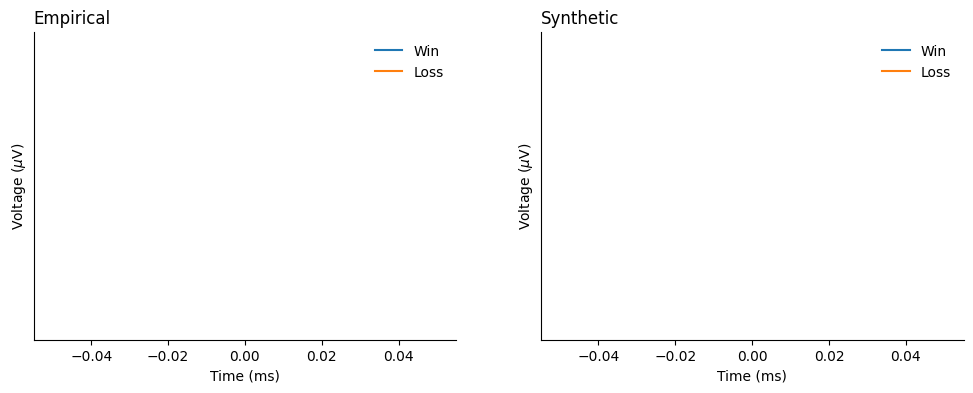

In [ ]:
#Define Filter Function
def filter_synthetic(EEG, fs=83.33):
    #Bandpass
    w = [x / fs for x in [0.1, 30]]
    b, a = signal.butter(4, w, 'band')

    #Process
    filteredEEG = [signal.filtfilt(b, a, EEG[trial,:]) for trial in range(len(EEG))] #Bandpass filter

    return np.array(filteredEEG)

#Filter synthetic data
syntheticEEG[:,:] = filter_synthetic(syntheticEEG[:,:])

#Grand average the synthetic waveforms for each condition
synLossWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,-2]==1],:],axis=0)
synWinWaveform = np.mean(syntheticEEG[np.r_[syntheticEEG[:,-2]==0],:],axis=0)
#
#Set up figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

#Plot each empirical waveform (note, we here add the same processing simply for visualization)
ax1.plot(time, scale(synWinWaveform), label = 'Win')
ax1.plot(time, scale(synLossWaveform), label = 'Loss')

#Format plot
ax1.set_ylabel('Voltage ($\mu$V)')
ax1.set_xlabel('Time (ms)')
ax1.set_title('Empirical', loc='left')
ax1.spines[['right', 'top']].set_visible(False)
ax1.tick_params(left = False, labelleft = False)
ax1.legend(frameon=False)

#Plot each synthetic waveform
ax2.plot(time, scale(synWinWaveform), label = 'Win')
ax2.plot(time, scale(synLossWaveform), label = 'Loss')

#Format plot
ax2.set_ylabel('Voltage ($\mu$V)')
ax2.set_xlabel('Time (ms)')
ax2.set_title('Synthetic', loc='left')
ax2.spines[['right', 'top']].set_visible(False)
ax2.tick_params(left = False, labelleft = False)
ax2.legend(frameon=False)

# Step 4. Classification

## Step 4.1. Preparing Validation Data
We also provide a validation dataset with samples not contained in the empirical dataset. Here, we prepare them for classification.

In [ ]:
#Set seed for a bit of reproducibility
rnd.seed(42)

#This function averages trial-level empirical data for each participant and condition
def averageEEG(EEG):
    participants = np.unique(EEG[:,0])
    averagedEEG = []
    for participant in participants:
        for condition in range(2):
            averagedEEG.append(np.mean(EEG[(EEG[:,0]==participant)&(EEG[:,1]==condition),:], axis=0))
    return np.array(averagedEEG)

#Load test data to predict (data that neither the GAN nor the classifier will ever see in training)
EEGDataTest = np.genfromtxt('data/eeggan_validation_example.csv', delimiter=',', skip_header=1)
EEGDataTest = averageEEG(EEGDataTest)[:,1:]

#Extract test outcome and predictor data
y_test = EEGDataTest[:,0]
x_test = EEGDataTest[:,3:]
x_test = scale(x_test,axis = 1)

## Step 4.2. Preparing Empirical Data
We now prepare the empirical training set. Our predictors will be the entire time series of 100 datapoints.

In [ ]:
#Create participant by condition averages
Emp_train = averageEEG(empiricalEEG)[:,1:]

#Extract the outcomes
Emp_Y_train = Emp_train[:,0]

#Scale the predictors
Emp_X_train = scale(Emp_train[:,3:], axis=1)

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Emp_X_train)),len(Emp_X_train))
Emp_Y_train = Emp_Y_train[trainShuffle]
Emp_X_train = Emp_X_train[trainShuffle,:]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:224: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:232: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:239: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may 

## Step 4.3. Preparing Augmented Data
We will prepare the augmented dataset by first processing the synthetic data as we did with the empirical data, then combining both the empirical and synthetic dataset to create an augmented dataset.

In [ ]:
#This function averages trial-level synthetic data in bundles of 50 trials, constrained to each condition
def averageSynthetic(synData):
    samplesToAverage = 50

    lossSynData = synData[synData[:,-2]==0,:]
    winSynData = synData[synData[:,-2]==1,:]

    lossTimeIndices = np.arange(0,lossSynData.shape[0],samplesToAverage)
    winTimeIndices = np.arange(0,winSynData.shape[0],samplesToAverage)

    newLossSynData = [np.insert(np.mean(lossSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,0) for trialIndex in lossTimeIndices]
    newWinSynData = [np.insert(np.mean(winSynData[int(trialIndex):int(trialIndex)+samplesToAverage,1:],axis=0),0,1) for trialIndex in winTimeIndices]

    avgSynData = np.vstack((np.asarray(newLossSynData),np.asarray(newWinSynData)))

    return avgSynData

#Create 'participant' by condition averages
Syn_train = averageSynthetic(syntheticEEG)

#Extract the outcomes
Syn_Y_train = Syn_train[:]

#Scale the predictors
Syn_X_train = scale(Syn_train[:,2:], axis=1)

#Combine empirical and synthetic datasets to create an augmented dataset
Aug_Y_train = np.concatenate((Emp_Y_train,Syn_Y_train))
Aug_X_train = np.concatenate((Emp_X_train,Syn_X_train))

#Shuffle the order of samples
trainShuffle = rnd.sample(range(len(Aug_X_train)),len(Aug_X_train))
Aug_Y_train = Aug_Y_train[trainShuffle]
Aug_X_train = Aug_X_train[trainShuffle,:]

NameError: name 'syntheticEEG' is not defined

# Step 5. Support Vector Machine

## Step 5.1. Define Search Space

In [ ]:
#Determine SVM search space
param_grid_SVM = [
    {'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']}]

## Step 5.2. Classify Empirical Data

In [ ]:
#Setup tracking variable
predictionScores_SVM = []

#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

ValueError: Input y contains NaN.

## Step 5.3. Classify Augmented Data

In [ ]:
#Setup SVM grid search
optimal_params = GridSearchCV(
    SVC(random_state=42),
    param_grid_SVM,
    refit = True,
    verbose = False)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train)
SVMOutput = optimal_params.predict(x_test)

#Determine performance
predictResults = classification_report(y_test, SVMOutput, output_dict=True)
predictionScores_SVM.append(round(predictResults['accuracy']*100))

#Report results
print(f"Empirical Classification Accuracy: {str(predictionScores_SVM[0])}%")
print(f"Augmented Classification Accuracy: {str(predictionScores_SVM[1])}%")

Empirical Classification Accuracy: 53%
Augmented Classification Accuracy: 69%


# Step 6. Neural Network

## Step 6.1. Define Search Space

In [ ]:
#Determine neural network search space
param_grid_NN = [
    {'hidden_layer_sizes': [(25,), (50,), (25, 25), (50,50), (50,25,50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [5000, 10000, 20000, 50000]}]

## Step 6.2. Classify Empirical Data

In [ ]:
#Signify computational time
print('This may take a few minutes...')

#Setup tracking variable
predictionScores_NN = []

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Emp_X_train, Emp_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Emp_X_train, Emp_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

This may take a few minutes...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits


## Step 6.3. Classify Augmented Data

In [ ]:
#Signify computational time
print('This may take twice as long as the empirical neural network classification...')

#Setup neural network grid search
optimal_params = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid_NN,
    verbose = True,
    n_jobs = -1)

#Conduct classification
optimal_params.fit(Aug_X_train, Aug_Y_train);
neuralNetOutput = MLPClassifier(hidden_layer_sizes=optimal_params.best_params_['hidden_layer_sizes'],
                            activation=optimal_params.best_params_['activation'],
                            solver = optimal_params.best_params_['solver'],
                            alpha = optimal_params.best_params_['alpha'],
                            learning_rate = optimal_params.best_params_['learning_rate'],
                            max_iter = optimal_params.best_params_['max_iter'])
neuralNetOutput.fit(Aug_X_train, Aug_Y_train)
y_true, y_pred = y_test , neuralNetOutput.predict(x_test)

#Determine performance
predictResults = classification_report(y_true, y_pred, output_dict=True)
predictScore = round(predictResults['accuracy']*100)
predictionScores_NN.append(predictScore)

#Report results
print(f"Empirical Classification Accuracy: {str(predictionScores_NN[0])}%")
print(f"Augmented Classification Accuracy: {str(predictionScores_NN[1])}%")

This may take twice as long as the empirical neural network classification...
Fitting 5 folds for each of 720 candidates, totalling 3600 fits
Empirical Classification Accuracy: 49%
Augmented Classification Accuracy: 70%


# Step 7. Final Report

## Step 7.1. Present Classification Performance
We present the performance accuracies in text.

In [ ]:
#Report results
print(f"{printFormat.bold}SVM Classification Results:{printFormat.end}")
print(f"Empirical Classification Accuracy: {predictionScores_SVM[0]}%")
print(f"Augmented Classification Accuracy: {predictionScores_SVM[1]}%")

# Report results
print(f"\n{printFormat.bold}Neural Network Classification Results:{printFormat.end}")
print(f"Empirical Classification Accuracy: {predictionScores_NN[0]}%")
print(f"Augmented Classification Accuracy: {predictionScores_NN[1]}%")
print(f"\n{printFormat.italic}Note: Due to randomization in this process, these accuracies will vary.{printFormat.end}")

SVM Classification Results:
Empirical Classification Accuracy: 53%
Augmented Classification Accuracy: 72%

Neural Network Classification Results:
Empirical Classification Accuracy: 49%
Augmented Classification Accuracy: 70%

Note: Due to randomization in this process, these accuracies will vary.


## Step 7.2. Plot Classification Performance
We present the performance accuracies in a plot.

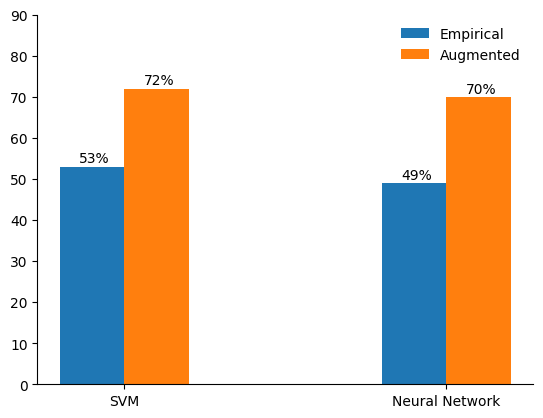

In [ ]:
ax = plt.subplot(111)
plt.bar([.9,1.9],[predictionScores_SVM[0],predictionScores_NN[0]], width=.2)
plt.bar([1.1,2.1],[predictionScores_SVM[1],predictionScores_NN[1]], width=.2)
plt.ylim([0,round((np.max([predictionScores_SVM,predictionScores_NN])+20)/10)*10])
predictionScores = predictionScores_SVM+predictionScores_NN
for xi, x in enumerate([.86,1.06,1.86,2.06]):
    plt.text(x,predictionScores[xi]+1,str(predictionScores[xi])+'%')
plt.xticks([1,2], labels = ['SVM', 'Neural Network'])
plt.legend(['Empirical','Augmented'], loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)